In [53]:
import glob
import ast
import os, re
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [54]:
pattern = "./consolidated cracks/*.txt"
rows = []

DATE_RE = re.compile(r"^\d{4}-\d{2}-\d{2}$")

In [55]:
for filepath in sorted(glob.glob(pattern)):
    filename = os.path.basename(filepath)
    date_str = filename.replace(".txt", "")
    year = date_str.split("-")[0]

    # Read file
    with open(filepath, "r") as f:
        file_content = f.read().strip()

    # Parse safely
    try:
        cracks_dict = ast.literal_eval(file_content)
    except Exception as e:
        print(f"Error reading {filename}: {e}")
        continue

    # Flatten cracks into rows
    for crack_name, coords_list in cracks_dict.items():
        for lat, lon in coords_list:
            rows.append([year, date_str, crack_name, lat, lon])

# Create DataFrame
df = pd.DataFrame(rows, columns=["year", "date", "crack", "lat", "lon"])

print(df.head())
print(f"Total rows: {len(df)}")

   year        date    crack        lat         lon
0  2014  2014-05-19  Crack 1  67.010664 -162.132102
1  2014  2014-05-19  Crack 1  67.008640 -162.129449
2  2014  2014-05-19  Crack 1  67.006616 -162.126797
3  2014  2014-05-19  Crack 1  67.004592 -162.124146
4  2014  2014-05-19  Crack 1  67.001028 -162.129183
Total rows: 4248


In [56]:
import math 

def segment_bearing_deg(lat1, lon1, lat2, lon2):
    """Initial great-circle bearing from (lat1,lon1) to (lat2,lon2), in [0,360)."""
    φ1, φ2 = math.radians(lat1), math.radians(lat2)
    Δλ = math.radians(lon2 - lon1)
    x = math.sin(Δλ) * math.cos(φ2)
    y = math.cos(φ1) * math.sin(φ2) - math.sin(φ1) * math.cos(φ2) * math.cos(Δλ)
    θ = math.degrees(math.atan2(x, y))
    return (θ + 360.0) % 360.0


In [57]:
from geopy import distance

grouped = df.groupby(["date", "crack"])
rows = []

for (date, crack), group in grouped:
    lats = group["lat"].tolist()
    lons = group["lon"].tolist()

    length = 0
    segment_lengths = []
    segment_bearings = []
    bearings = []

    for i in range(1, len(lats)):
        p1 = (lats[i-1], lons[i-1])
        p2 = (lats[i], lons[i])
        length += abs(distance.distance(p1,p2).km)
        segment_lengths.append(abs(distance.distance(p1,p2).km))
        segment_bearings.append(segment_bearing_deg(p1[0], p1[1], p2[0], p2[1]))
    # make axial
    for b in segment_bearings:
        b = b % 180
        if b < 0: # if less than zero reflect into first two quadrants
            b += 180
        if b > 90: # if greater than 90 degrees find deviation from true north
            b = 180 - b
        bearings.append(b)
    rows.append([date, crack, length, bearings])

lo = pd.DataFrame(rows, columns=["date", "crack", "length", "bearings"])
print(bearings)

[72.59821996173409, 72.59266607833342, 72.58711253022693, 72.5815593193741, 72.5760064456195, 72.57045390827761, 72.56490170775515, 72.55934984418167, 72.5537983179301, 72.5482471285004, 72.54269627624018]


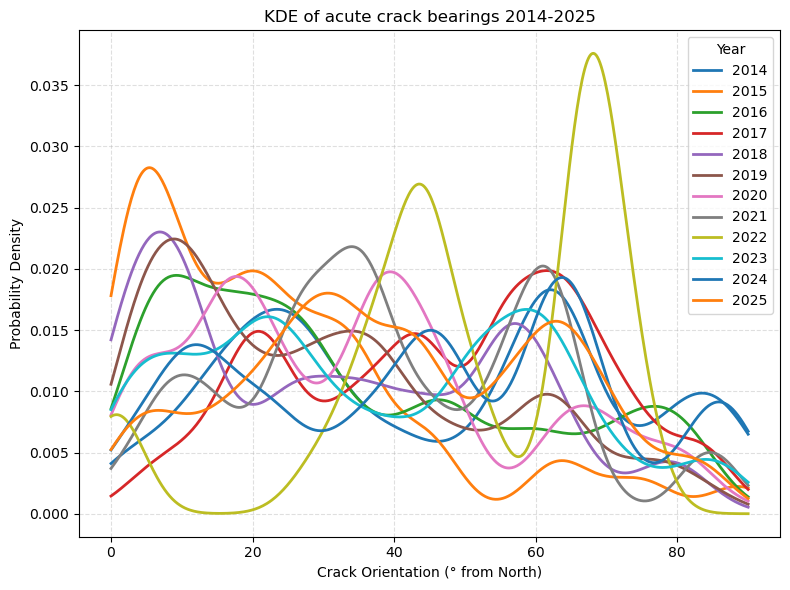

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
import seaborn as sns

# assuming lo DataFrame has ["date", "crack", "length", "bearings"]
lo["year"] = pd.to_datetime(lo["date"]).dt.year

plt.figure(figsize=(8, 6))
colors = plt.cm.tab10.colors

for i, (year, group) in enumerate(lo.groupby("year")):
    bearings = np.concatenate(group["bearings"].values)
    bearings = bearings[np.isfinite(bearings)]
    if len(bearings) == 0:
        continue
    # visualize with gaussian kde to look for peaks
    kde = gaussian_kde(bearings, bw_method=0.2)  # smaller bw = noisier, larger = smoother
    x = np.linspace(0, 90, 500)
    density = kde(x)

    plt.plot(x, density, color=colors[i % len(colors)], lw=2, label=str(year))

plt.xlabel("Crack Orientation (° from North)")
plt.ylabel("Probability Density")
plt.title("KDE of acute crack bearings 2014-2025")
plt.legend(title="Year")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()



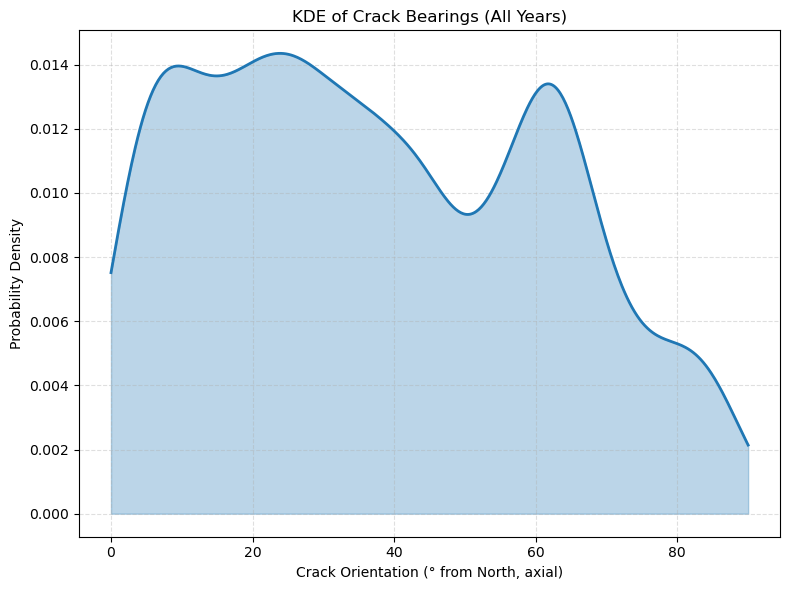

In [62]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde

# --- assuming lo has a "bearings" column containing lists or arrays of angles ---
# flatten all bearings
bearings = np.concatenate(lo["bearings"].values)
bearings = bearings[np.isfinite(bearings)]

# --- KDE smoothing ---
kde = gaussian_kde(bearings, bw_method=0.2)  # adjust bw for smoothing
x = np.linspace(0, 90, 500)
density = kde(x)

# --- plot ---
plt.figure(figsize=(8, 6))
plt.plot(x, density, color="tab:blue", lw=2)
plt.fill_between(x, density, color="tab:blue", alpha=0.3)
plt.xlabel("Crack Orientation (° from North, axial)")
plt.ylabel("Probability Density")
plt.title("KDE of Crack Bearings (All Years)")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()


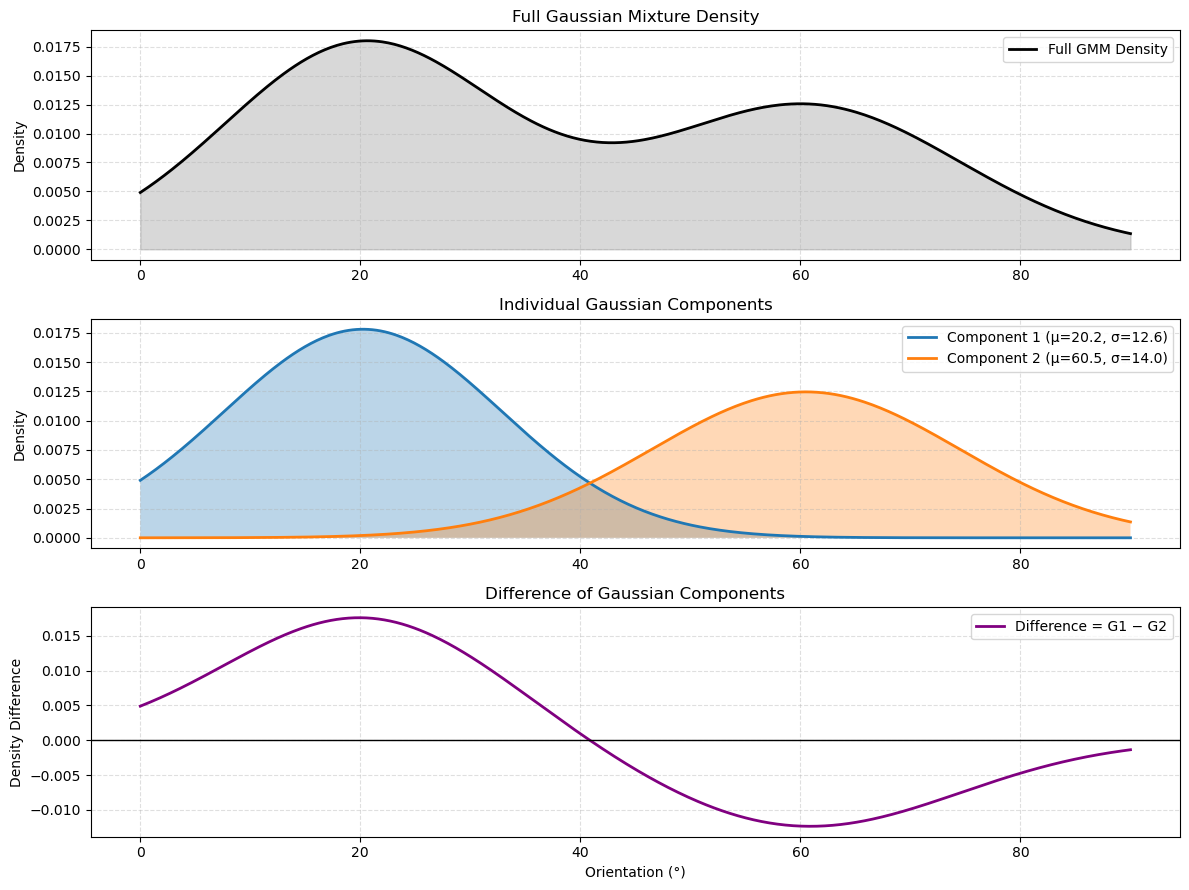

In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

bearings = np.concatenate(lo["bearings"].values)
bearings = bearings[np.isfinite(bearings)]

bearings = bearings.reshape(-1, 1)

# Fit gmm
gmm = GaussianMixture(n_components=2, random_state=0)
gmm.fit(bearings)

# Evaluate gmm on the same 90 degree domain
x = np.linspace(0, 90, 500).reshape(-1, 1)

# Total density
density = np.exp(gmm.score_samples(x))

# Individual component densities
def gaussian_pdf(x, mean, std):
    return (1 / (std * np.sqrt(2*np.pi))) * np.exp(-0.5*((x - mean)/std)**2)

means = gmm.means_.flatten()
stds = np.sqrt(gmm.covariances_).flatten()
weights = gmm.weights_

component_densities = [
    (weights[k] * gaussian_pdf(x, means[k], stds[k])).flatten()
    for k in range(2)
]

# Difference of the two Gaussians (component 1 − component 2)
difference = component_densities[0] - component_densities[1]

# PLOTTING

plt.figure(figsize=(12, 9))

# Plot the full gmm density
plt.subplot(3, 1, 1)
plt.plot(x, density, lw=2, color="black", label="Full GMM Density")
plt.fill_between(x.flatten(), density, alpha=0.3, color="gray")
plt.title("Full Gaussian Mixture Density")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

# Plot each component as its own gaussian distribution
plt.subplot(3, 1, 2)
plt.plot(x, component_densities[0], lw=2, label=f"Component 1 (μ={means[0]:.1f}, σ={stds[0]:.1f})")
plt.plot(x, component_densities[1], lw=2, label=f"Component 2 (μ={means[1]:.1f}, σ={stds[1]:.1f})")

plt.fill_between(x.flatten(), component_densities[0], alpha=0.3)
plt.fill_between(x.flatten(), component_densities[1], alpha=0.3)

plt.title("Individual Gaussian Components")
plt.ylabel("Density")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

# Plot the difference between the gaussians
plt.subplot(3, 1, 3)
plt.plot(x, difference, lw=2, color="purple", label="Difference = G1 − G2")
plt.axhline(0, color="black", lw=1)

plt.title("Difference of Gaussian Components")
plt.xlabel("Orientation (°)")
plt.ylabel("Density Difference")
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend()

plt.tight_layout()
plt.show()
